In [0]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.metrics import accuracy_score

import time
import copy
import tensorflow as tf
sns.set()

In [0]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = (y == 3).astype(int) * 2 - 1
    return x,y

In [0]:
x_train36, y_train36 = filter_36(x_train, y_train)
x_test36, y_test36 = filter_36(x_test, y_test)

In [0]:
X_tr = x_train36.reshape((-1, 28*28))
Y_tr = y_train36.reshape((-1, 1))
X_te = x_test36.reshape((-1, 28*28))
Y_te = y_test36.reshape((-1, 1))

In [0]:
pca = PCA(n_components = 100)
X_train_pca = pca.fit_transform(X_tr)
X_test_pca = pca.transform(X_te)

In [0]:
mean = np.mean(X_train_pca, axis = 0)
std = np.std(X_train_pca, axis = 0)

In [0]:
X_train_norm = (X_train_pca - mean) / std
X_test_norm = (X_test_pca - mean) / std

In [0]:
X_train = np.hstack((X_train_norm, np.ones((X_train_norm.shape[0], 1))))
X_test = np.hstack((X_test_norm, np.ones((X_test_norm.shape[0], 1))))

In [0]:
def batch(X, y, r):
    N = len(X)
    inds = np.random.choice(N, r, replace=False)
    return np.copy(X[inds]), np.copy(y[inds])

In [0]:
def func(c, x, y, C=1.0):
    c_norm = np.linalg.norm(c, axis=-1) ** 2 / 2
    r = c @ x.T
    g = np.multiply(y.T, r)
    return c_norm + np.mean(np.maximum(0, 1 - g), axis=-1)

In [0]:
def grad(c, x, y, C=1.0):
    N = len(x)
    r = c @ x.T
    g = np.multiply(y.T, r)
    mask = (1 - g) > 0
    inds = mask.squeeze(0)
    return (c - C * np.sum(x[inds]*y[inds], axis = 0) / N).T

In [0]:
def ellipsoid_method(X, Y, N, c0, H, r=10):
    n = c0.shape[1]
    сs = np.array([c0])
    for i in range(N):
        c = copy.copy(сs[-1])
        x, y = batch(X, Y, r)
        w = grad(c, x, y)
        w_norm = (w.T @ H @ w)[0][0]

        if np.linalg.norm(w_norm) < 1e-101:
            return сs
        
        const1 = (np.sqrt(np.abs(w_norm)) * (n+1))
        c -= (H @ w).T / const1
        
        const2 = (n*n - 1) / n*n   
        H = (H - 2/(n+1) * (H @ w @ w.T @ H) / w_norm) / const2
    
        сs = np.vstack((сs, [c]))
    return сs

In [0]:
def gradient_descent(X, Y, N, c0, mu=0.01, r=10):
    n = c0.shape[1]
    сs = np.array([c0])
    for i in range(11):
        c = copy.copy(сs[-1])
        x, y = batch(X, Y, r)
        w = grad(c, x, y)
        
        c -= mu * w.T
        сs = np.vstack((сs, [c]))
    return сs

In [0]:
n = X_train.shape[1]
H = np.eye(n) * 5
c = np.zeros((1, n))

In [0]:
rs = np.linspace(1, 12000, 500).astype(int)

In [0]:
acc_plot = []
time_plot = []

for r in rs:
    acc = []
    start = time.process_time()
    for _ in range(30):
        H = np.eye(n) * 5
        c = np.zeros((1, n))

        res = ellipsoid_method(X_train, Y_tr, 10, c, H, r=r)
        ind = np.argmin(func(res, X_train, Y_tr))
        best_c = res[ind]

        y_pred = np.sign(X_test @ best_c.T)
        tmp = accuracy_score(Y_te, y_pred)
        acc.append(tmp)
    end = time.process_time() - start
    acc_plot.append(np.mean(acc))
    time_plot.append(end)

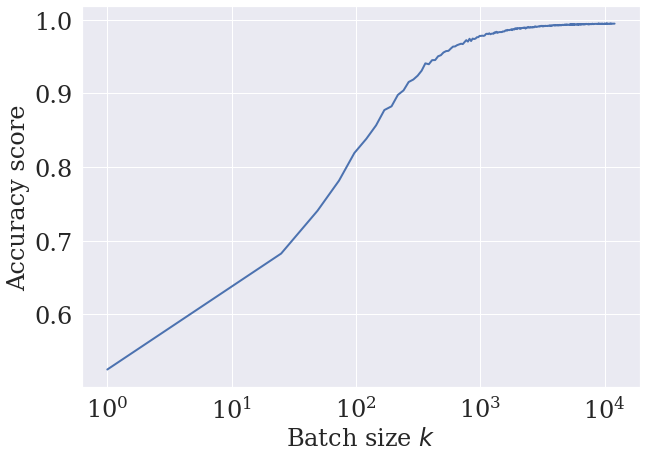

In [0]:
plt.figure(figsize=(10,7))
plt.plot(rs, acc_plot)
plt.xlabel(r"Batch size $k$")
plt.ylabel("Accuracy score")
plt.xscale("log")
plt.savefig("plt.eps")
plt.show()

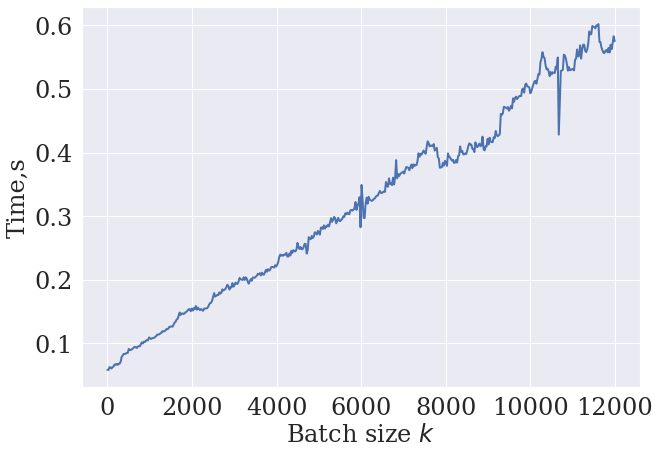

In [0]:
plt.figure(figsize=(10,7))
plt.plot(rs, np.array(time_plot) / 30)
plt.xlabel(r"Batch size $k$")
plt.ylabel("Time,s")
plt.savefig("time.eps")
plt.show()